In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import itertools
import imageio

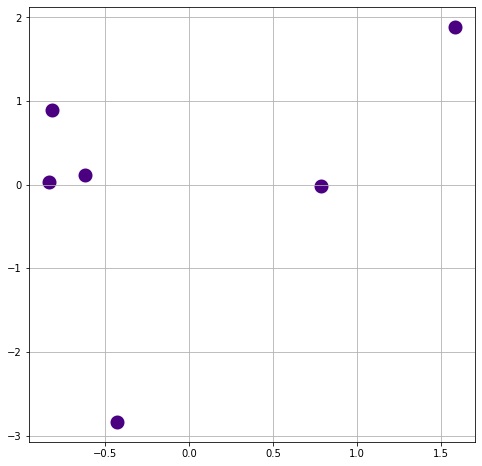

In [2]:
data = np.random.normal(size=(6, 2))

sample = 'normal'

data_count, data_dim = data.shape


plt.figure(figsize=(8, 8))
plt.scatter(data[:, 0], data[:, 1], color='indigo', linewidth=8)
plt.grid(True)
plt.show()

# Search simplicies

In [3]:
test_radius = 0.75

## Dimension 0

In [4]:
def simplex_radiuses_dim0(data, norm=np.linalg.norm):
    return np.zeros(data.shape[0])

## Dimension 1

In [5]:
def simplex_radiuses_dim1(data, norm=np.linalg.norm):
    n = data.shape[0]
    d = data*np.ones(np.append(n, data.shape))
    d = d - d.transpose([1, 0, 2])
    d = 0.5*norm(d, axis=2)
    d[np.eye(n)==1] = np.inf
    return d

## Dimension 2

In [6]:
def simplex_radiuses_dim2(data, norm=np.linalg.norm):
    radiuses_dim1 = simplex_radiuses_dim1(data, norm)
    radiuses_dim1 = radiuses_dim1.reshape(np.append(1, radiuses_dim1.shape)) * np.ones([radiuses_dim1.shape[0], 1, 1])
    axises = [(0, 1, 2), (1, 2, 0), (2, 0, 1)]
    framed = np.array([radiuses_dim1.transpose(axis) for axis in axises])
    framed = np.max(framed, axis=0)
    # Отделены все обрамлённые
    # Нужно также выявить радиусы удаления дырок и исключить пересечения
    pass
    return framed

# Analyse spaces

In [7]:
def get_radiuses(data, norm=np.linalg.norm):
    l0 = simplex_radiuses_dim0(data)
    l0 = l0[l0 < np.inf]
    l1 = simplex_radiuses_dim1(data)
    l1 = l1[l1 < np.inf]
    l2 = simplex_radiuses_dim2(data)
    l2 = l2[l2 < np.inf]
    l = np.concatenate([l0, l1, l2])
    l = np.unique(l)
    return l

In [8]:
def get_space(data, radius, norm=np.linalg.norm):
    res = {
        0 : np.where(simplex_radiuses_dim0(data, norm) <= radius)[0], 
        1 : np.array(np.where(simplex_radiuses_dim1(data, norm) <= radius)).transpose(), 
        2 : np.array(np.where(simplex_radiuses_dim2(data, norm) <= radius)).transpose(), 
    }
    for i in range(1, 3):
        res[i] = np.sort(res[i], axis=1)
        res[i] = np.unique(res[i], axis=0)
    return res

In [9]:
def get_radius_spaces(data, norm=np.linalg.norm):
    res = {}
    for radius in get_radiuses(data, norm):
        res.update({radius : get_space(data, radius, norm=norm)})
    return res

In [10]:
def number_connected_components(space):
    """
    Returns number of connected components.
    
    Parameters:
    -----------
    space : dict
        Simplex space. Keys are dimensions, values are list of simplicies.
    
    Returns:
    --------
    num : int
        Number of connected components.
    """
    graph = nx.Graph()
    graph.add_nodes_from(space[0])
    graph.add_edges_from(space[1])
    num = nx.algorithms.components.number_connected_components(graph)
    return num

In [11]:
spaces = get_radius_spaces(data)
pd.DataFrame({
    'Radius' : [r for r in spaces],
    'Simplices dim 0' : [len(spaces[r][0]) for r in spaces], 
    'Simplices dim 1' : [len(spaces[r][1]) for r in spaces], 
    'Simplices dim 2' : [len(spaces[r][2]) for r in spaces], 
    'Connected components' : [number_connected_components(spaces[r]) for r in spaces]
})

,Radius,Simplices dim 0,Simplices dim 1,Simplices dim 2,Connected components
0,0.000000,6,0,0,6
1,0.112962,6,1,0,5
2,0.405688,6,2,0,4
3,0.432767,6,3,1,4
4,0.705338,6,4,1,3
5,0.808567,6,5,2,3
6,0.923790,6,6,4,3
7,1.035461,6,7,4,2
8,1.299436,6,8,5,2
9,1.415925,6,9,7,2


# Visualization

In [12]:
def draw_balls(data, radius, color='orchid', linewidth=0, alpha=0.5, circle_points=24, fill=True, ax=plt):
    """
    Plots balls arround points from data.
    
    Parameters:
    -----------
    data : np.ndarray or list of np.ndarrays
        List of points.
        
    radius : float
        Ball radius.
        
    color : color or rgba tuple
        
    linewidth : scalar
        
    alpha : float
        The alpha blending value, between 0 (transparent) and 1 (opaque).
            
    circle_points : int
        Number of points in circle. (If fill is True, then that will be number of ponts in top and bot arc)
        
    fill : bool
        Fill circle if True.
        
    ax : matplotlib.pyplot or Axes class
    """
    if fill:
        arc_x = radius*np.cos(np.pi*np.arange(circle_points+1)/circle_points)
        arc_y1 = radius*np.sin(np.pi*np.arange(circle_points+1)/circle_points)
        arc_y2 = radius*np.sin(-np.pi*np.arange(circle_points+1)/circle_points)
        for point in data:
            ax.fill_between(x=point[0] + arc_x, y1=point[1] + arc_y1, y2=point[1] + arc_y2,
                            color=color, linewidth=linewidth, alpha=alpha)
    else:
        circle_x = radius*np.cos(2*np.pi*np.arange(circle_points+1)/circle_points)
        circle_y = radius*np.sin(2*np.pi*np.arange(circle_points+1)/circle_points)
        for point in data:
            ax.plot(point[0] + circle_x, point[1] + circle_y, color=color, linewidth=linewidth, alpha=alpha)

In [13]:
def draw_simplicies(data, edges=[], triangles=[],
                    node_color='indigo', node_width=8, node_alpha=1,
                    edge_color='steelblue', edge_width=4, edge_alpha=1,
                    triangle_color='aquamarine', triangle_alpha=0.7, ax=plt):
    """
    Plots nodes edges and triangles of all simplicies.
    
    Parameters:
    -----------
    data : np.ndarray or list of np.ndarrays
        List of points (nodes).
            
    edges : list of tuples
        List of node pairs.
            
    triangles : list of tuples
        List of triangle triples.
            
    node_color : color or rgba tuple
        Node color.
            
    node_width : scalar
        Linewidth of nodes.
        
    node_alpha : float
        The alpha blending value for node, between 0 (transparent) and 1 (opaque).

    edge_color : color or rgba tuple
        Edge color.
            
    edge_width : scalar
        Linewidth of edges.
        
    edge_alpha : float
        The alpha blending value for edge, between 0 (transparent) and 1 (opaque).
            
    triangle_color : color or rgba tuple
        Triangle fill color.
        
    node_alpha : float
        The alpha blending value for filled triangle, between 0 (transparent) and 1 (opaque).
        
    ax : matplotlib.pyplot or Axes class
    """
    for triangle in triangles:
        xs = [data[i][0] for i in triangle]
        ys = [data[i][1] for i in triangle]
        ax.fill(xs, ys, color=triangle_color, alpha=triangle_alpha)
    for edge in edges:
        p0 = data[edge[0]]
        p1 = data[edge[1]]
        ax.plot([p0[0], p1[0]], [p0[1], p1[1]], color=edge_color, linewidth=edge_width, alpha=edge_alpha)
    for point in data:
        ax.scatter(point[0], point[1], color=node_color, linewidth=node_width, alpha=node_alpha)

In [14]:
filetemplate = 'simplex2dnp'
filename = filetemplate + '_' + sample + '_dim' + str(data_dim) + '_count' + str(data_count)
filename

'simplex2dnp_normal_dim2_count6'

In [15]:
visible_radiuses = np.arange(0, 1.61, 0.05)
len(visible_radiuses)

33

In [16]:
for radius in visible_radiuses:
    space = get_space(data, radius)
    edges = space[1]
    triangles = space[2]
    
    plt.figure(figsize=(12, 12))
    plt.title('$R = ' + str('{:.3f}'.format(radius)) +'$', fontdict={'fontsize':24})
    draw_balls(data, radius, color='orchid', alpha=0.15, ax=plt)
    draw_simplicies(data, edges=edges, triangles=triangles)
    plt.grid(True)
    plt.savefig('pics/' + filename + str(radius).replace('.', '_') + '.png')
    plt.close()

In [17]:
images = [imageio.imread('pics/' + filename + str(radius).replace('.', '_') + '.png') for radius in visible_radiuses]
imageio.mimsave(filename + '.gif', images)